In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as imbpipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR

In [2]:
def grid_model(model_name):

    if model_name == 'rfr':
        model = RandomForestRegressor(n_estimators = 10,random_state=0)

        #hypeparameters combination of random forest model to test in the grid search
        hyper_params = {
        'model__n_estimators': [3,5,10,20], 
        'model__max_depth': [2,3,5,10], 
        #'model__min_samples_split':[2,6]
        }

    elif model_name == 'svr':
        model = SVR(kernel = 'rbf')

    elif model_name == 'lr':
        model = LinearRegression()
        hyper_params = {
        'model__n_jobs': [1,3],   
        }
    
    elif model_name == 'lasso':
        model = Lasso(random_state=0, max_iter=50000)
        hyper_params = {
        'model__alpha': np.logspace(-4, -0.5, 5),   
        }

    elif model_name == 'ridge':
        model = Ridge()
        hyper_params = {
        'model__alpha': [0.1,1.0],     
        }

    #defining the pipeline steps for each model
    pipeline = imbpipeline(steps=[
    ('imputer', KNNImputer(missing_values=np.nan,n_neighbors = 3,add_indicator=False)), #transform: solve missing values 
    ('scaler', StandardScaler()),                                     #transform: standart normalization of values (mean = 0, std = 1)
    ('model',model)  #classifier: constructs a lot of decision trees and uses the class selected by most trees
                        ])


    # grid search definition
    grid = GridSearchCV(
        pipeline,
        param_grid = hyper_params,
        scoring = 'neg_mean_squared_error',   #balance between precision (true positives compared to all the positives) and recall(trues found compared to the total trues)
        cv = 5,
        n_jobs = 1)

    return grid

In [3]:
df_training = pd.read_csv('processed_data/training_data.csv')


results = {}
for model_name in ['rfr']:#,'lasso','ridge']:
    print(model_name)
    grid = grid_model(model_name)

    for model_of_area in df_training["Área"].unique():
        print('model calculated using data of:', model_of_area)
        y = df_training[df_training.Área == model_of_area].AveragePerformance                        #target prediction
        X = df_training[df_training.Área == model_of_area].drop(['AveragePerformance',"Área"], axis = 1)

        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3,random_state = 0)

        grid = grid.fit(X_train, y_train)

        MSE_modelo = []
        modelo_aplicado_em = []
        for area in df_training["Área"].unique():
            print('model applied in data of:',area)
            y = df_training[df_training.Área == area].AveragePerformance                        #target prediction
            X = df_training[df_training.Área == area].drop(['AveragePerformance',"Área"], axis = 1)

            X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3,random_state = 0)

            prediction = grid.predict(X_test)
            mse = mean_squared_error(y_test, prediction)

            modelo_aplicado_em.append(area)
            MSE_modelo.append(round(mse,2))

        results[model_of_area] = MSE_modelo
    
    
    y = df_training.AveragePerformance                        #target prediction
    X = df_training.drop(['AveragePerformance'], axis = 1)

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3,random_state = 0)

    X_train_no_Area = X_train.drop(['Área'],axis=1)
    grid = grid.fit(X_train_no_Area, y_train)

    MSE_modelo = []
    for area in df_training["Área"].unique():
        print('total model applied in data of:',area)

        X_test['AveragePerformance'] = y_test
        try:
            X_test = X_test.drop(['Unnamed: 0'],axis=1)
        except:
            pass
        X_test_this_area = X_test[X_test.Área == area].drop(["Área"], axis = 1)
        y_test_this_area = X_test[X_test.Área == area].AveragePerformance 

        prediction = grid.predict(X_test_this_area)
        mse = mean_squared_error(y_test_this_area, prediction)

        MSE_modelo.append(round(mse,2))
    
    results["Todas"] = MSE_modelo

results['ModeloAplicadoEm'] = modelo_aplicado_em
results = pd.DataFrame(results)
results = results.set_index(['ModeloAplicadoEm'])

rfr
model calculated using data of: Operações
model applied in data of: Operações
model applied in data of: Logística
model applied in data of: Financeiro
model applied in data of: Pessoas
model applied in data of: Comercial
model calculated using data of: Logística
model applied in data of: Operações
model applied in data of: Logística
model applied in data of: Financeiro
model applied in data of: Pessoas
model applied in data of: Comercial
model calculated using data of: Financeiro
model applied in data of: Operações
model applied in data of: Logística
model applied in data of: Financeiro
model applied in data of: Pessoas
model applied in data of: Comercial
model calculated using data of: Pessoas
model applied in data of: Operações
model applied in data of: Logística
model applied in data of: Financeiro
model applied in data of: Pessoas
model applied in data of: Comercial
model calculated using data of: Comercial
model applied in data of: Operações
model applied in data of: Logística

/home/renata/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0.5, 1.0, 'Models mean_squared_error')

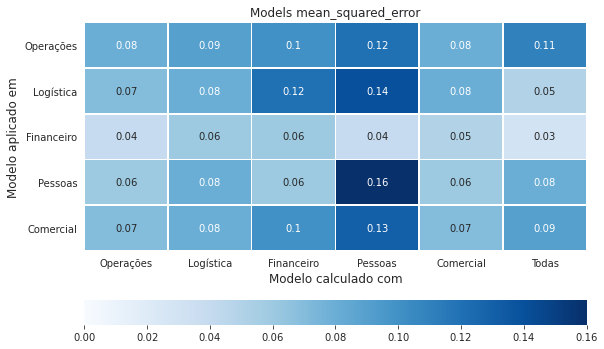

In [4]:
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(9, 6))
s = sns.heatmap(results,annot=True, linewidths=.5,cmap=plt.cm.Blues, ax=ax,vmin=0,cbar_kws={"orientation": "horizontal"})
s.set_xlabel('Modelo calculado com', fontsize=12)
s.set_ylabel('Modelo aplicado em', fontsize=12)
s.set_title('Models mean_squared_error')

In [5]:
df_training["Área"].value_counts()

Operações     599
Comercial     557
Logística     214
Financeiro     84
Pessoas        72
Name: Área, dtype: int64

### Make previsions about data with no performance

In [6]:
df_test = pd.read_csv('processed_data/test_data.csv')
X_test = df_test.drop(['Área'], axis = 1)

In [7]:
X_test['Prediction']= grid.predict(X_test)

In [8]:
X_test

,Unnamed: 0,Potencial Bruto,Raciocínio,Social,Motivacional,Cultura pontuação,atributo-Capacidade analítica,atributo-Pensamento conceitual,atributo-Reflexão,atributo-Pensamento criativo,...,perfil-Sociabilidade,perfil-Facilitação,perfil-Flexibilidade,perfil-Estabilidade emocional,perfil-Ambição,perfil-Iniciativa,perfil-Assertividade,perfil-Tomada de riscos,ModePerformance,Prediction
0,369,40.64,24.91,50.82,51.56,11.30,46.15,35.93,16.03,22.29,...,41.95,41.95,55.59,69.23,51.05,82.86,14.68,32.86,NaN,2.011599
1,391,NaN,81.73,NaN,NaN,61.09,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.011599
2,417,NaN,47.07,NaN,NaN,30.16,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.011599
3,448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.011599
4,488,NaN,50.63,NaN,NaN,61.74,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.011599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
738,1878,57.43,64.72,60.70,41.17,49.39,75.73,41.64,68.91,31.41,...,78.32,69.23,51.05,32.86,23.77,90.56,69.23,28.32,NaN,2.316876
739,1879,NaN,30.57,NaN,NaN,36.68,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.316876
740,1880,NaN,28.77,NaN,NaN,24.76,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.316876
741,1882,NaN,25.05,NaN,NaN,19.61,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.428748
